# **BAYESIAN MODELS**

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as sps
import scipy.integrate as spi
import scipy.special as spsc
import scipy.optimize as spo

import matplotlib.pyplot as plt


## **Contents**

1. Basic bayes

      a. Bayes theorem

      b. Bayesian statistics

      c. Using prior knowledge


2. Bayesian observers

      a. Neural orientation likelihoods

      b. Cardinal prior

      c. Biological implementation


3. Bayesian cognition

      a. Tomorrow's prior

      b. Optimal vs Human

      c. Estimating suboptimalities

## Part 1: Basic Bayes

### 1a. Bayes Theorem

Bayes' theorem looks rather simple:

\begin{align}
 p(A|B) = \frac{p(B|A) p(A)} {p(B)}
\end{align}

\\
The probability of A given B is equal to the probability of B given A multiplied by the probability of A, divided by the probability of B. But many people find this unintuitive, generating what's known as base-rate neglect (Kahneman & Tversky, 1973). The typical example is:

*Suppose that 0.1% of all people in a population carry a virus. A
diagnostic test for this virus detects it in 100% of the people who have the virus, but also gives false alarms on 5% of the people who do not have the virus. What is the chance that a person with a positive test result actually has the virus?*

In a recent experiment (Stengard et al., Cognition, 2022) found the modal response was "95%" (~20% of participants).

Calculate the correct response using Bayes Theorem. Use A = "having the virus" and B = "testing positive"

In [2]:
# Define pA, the probability of having the virus
pA = 0.001

# Define pBA, the probability of testing positive given you have the virus
pBA = 1

# Define pB, the probability of testing positive
# This is the sum of the 0.1% of the population who have the virus and will
# test positive, plus the 99.9% of the population who have a 5% chance of
# testing positive
pB = ((1-0.001)*0.05)+0.001

# Apply Bayes theorem, pAB = (pBA*pA)/pB and print the result
pAB = (pBA*pA)/pB
print(pAB)

0.019627085377821395


Stengard et al., found just 9% of participants gave an answer between 1.8% and 2.2%, in line with previous studies, where the correct answer is given less than 20% of the time.

If you found that unintuitive, try another (Based on Bar-Hillel, 1980):

*In the city, 85% of cabs are blue and 15% are green. In a hit and run accident, an eye-witness identifies a green cab. The accident happened at night, and when tested, it was found the witness confuses blue and green at night 20% of the time. What is the chance the cab was green?*

A = "cab is green", B = "witness sees green"

In [3]:
# Define pA, the probability that the cab is green
pA = 0.15

# Define pBA, the probability that the witness reports a green cab is green
pBA = 0.8

# Define pB, the probability that the witness reports a green cab, given either
# a green or a blue cab
pB = (0.85*0.2)+(0.15*0.8)

# Apply Bayes and print the result
pAB = (pBA*pA)/pB
print(pAB)

0.4137931034482758


Correct answer: 41.38%

### 1b. Bayesian Statistics

The terms of Bayes theorem are often referred to as:
- the posterior $p(A|B)$,
- the likelihood $p(B|A)$,
- the prior $p(A)$, and
- the marginal likelihood $p(B)$.

Here we use the term 'likelihood'.

Note that probabilities have to add to 1: $p(A) = 1 - p({\displaystyle \neg }A)$, likelihoods do not.

In Bayesian statistics, we think about this in terms of data (e.g., a random variable $\boldsymbol{x}$) and model parameters $\theta$: We ask, *what is the probability of the model parameter, given the data, $p(\theta | \boldsymbol{x})$?*

For example, what is the probability of the null hypothesis that the mean is 0? Which is calculated as the probability of the data given the model parameter $p(\boldsymbol{x}|\theta)$, multiplied by the prior probability of model parameter $p(\theta)$. Therefore, Bayes theorem in the context of parameter estimation is

\begin{align}
 p(\theta|\boldsymbol{x}) = \frac{p(\boldsymbol{x}|\theta) p(\theta)} {p(\boldsymbol{x})}
\end{align}


\\


Simple example: We observe N = 20 samples of data $\boldsymbol{x}$, which have been sampled from a Gaussian with a true mean $\mu = 0$ and standard deviation $\sigma = 1$: $\boldsymbol{x} \sim \mathcal{N}(0, 1)$. Our parameters are $\theta = \{\mu, \sigma \}$.

\\

Use `sps.norm.rvs(loc=mu, scale=sigma, size=N)` to take 20 samples of data.

In [4]:
# take 20 random samples from a Normal distribution
mu = 0
sigma = 1

data = sps.norm.rvs(mu, sigma, size=20)

 Assume we know the true standard deviation is 1, but we're unsure about  the true mean: it could be anywhere between -1 and 1, with equal likelihood (uniform/uninformative prior).

In [5]:
# Prior function: A function of mu that uses sps.uniform.pdf to calculate the
# likelihood of mu under the prior uniform distribution; location = -1, scale = 2
def uniform_prior(mu):

    prior = sps.uniform.pdf(x=mu, loc=-1, scale=2)

    return prior


# Likelihood function: returns the likelihood of the data given mu. The input
# The likelihood function is a normal distribution: sps.norm.pdf with scale
# (sigma) fixed to 1 (because we are assuming we know the true standard deviation)
def likelihood(data, mu):

    lh = sps.norm.pdf(x=data, loc=mu, scale=1)

    return lh

The posterior can be calculated as proportional to the prior multiplied by the likelihood: $p(\theta | \boldsymbol{x}) \propto p(\theta) p(\boldsymbol{x} | \theta)$.

For now, ignore the marginal likelihood $p(\boldsymbol{x})$.

In [6]:
# Define a function to return the posterior:
# uniform_prior(mu) * likelihood(data, mu)
# Hint: the posterior is the product over the data samples

def posterior_prod(mu, data):

    post = uniform_prior(mu) * likelihood(data, mu)

    return np.prod(post)

To visualise, make a histogram of the data and overlay distributions with 10 possible means.

Text(0, 0.5, 'Density')

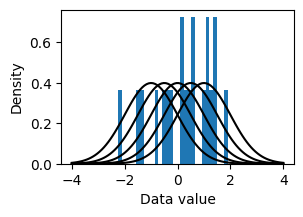

In [7]:
# Use np.linspace to take 5 possible means between -1 and 1
mus = np.linspace(-1, 1, 5)

# For the x-axis, take 100 possible values between -4 and 4
xs = np.linspace(-4, 4, 100)

# Plot a histogram of the observed data (use density=True)
plt.figure(figsize=(3,2), dpi=100)

plt.hist(data, bins=30, density=True)

# Overlay the expected distributions for each of the 5 possible mus
# You can use the likelihood function with data=xs (the x-axis values)
for m in mus:
    plt.plot(xs, likelihood(xs, m), 'k')

plt.xlabel('Data value')
plt.ylabel('Density')

Plot the prior, the likelihood, and the posterior, over 100 discrete possible means.

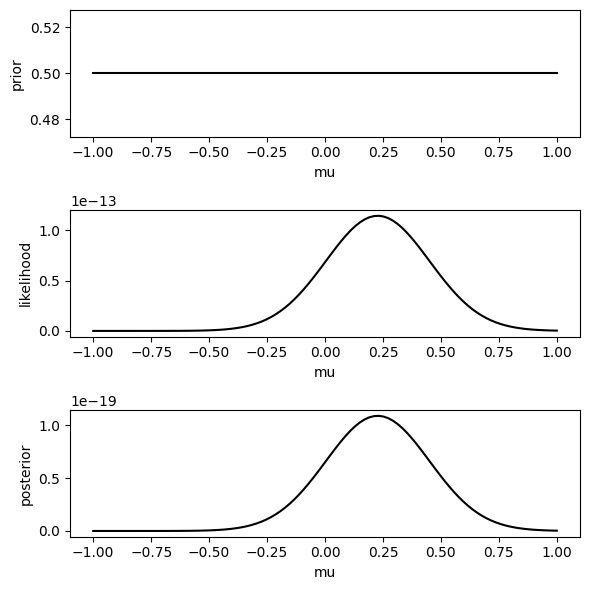

In [8]:
# Define a new x-axis, which is 100 possible mus evenly spaced between -1 and 1
mus = np.linspace(-1, 1, 100)


fig = plt.figure(figsize=(6,6))
ax = fig.subplots(3, 1)
# On  subplot 1, plot the uniform prior function of mu


ax[0].plot(mus, uniform_prior(mus), 'k')
ax[0].set(xlabel='mu', ylabel='prior')

# On a second subplot, plot the likelihood of the data as a function of mu
# The likelihood is the product across data samples, so take the output of the
# likelihood function as a numpy array
lhs = np.array([likelihood(data, m) for m in mus])

ax[1].plot(mus, np.prod(lhs, axis=1), 'k')
ax[1].set(xlabel='mu', ylabel='likelihood')

# Calculate the posterior, using the functions, for each possible mu
post = np.array([posterior_prod(m, data) for m in mus])

# Plot on the third subplot
ax[2].plot(mus, post, 'k')
ax[2].set(xlabel='mu', ylabel='posterior')

plt.tight_layout()

What is the posterior probability of the null hypothesis that the mean
is 0?


In [9]:
# Define pH0, the value of the posterior at mean = 0 and print the value
pH0 = posterior_prod(m, data)
print(pH0)

2.7831557016502938e-22


What is the posterior probability of alternative hypothesis 1: the mean is greater than 0 (up to 1)?

For this, we could do some math (integrate over values from 0 to 1), but in reality we're often faced with more complicated problems that don't have simple mathematical solutions... We can use numerical integration to estimate the probability density under the posterior from 0 to 1. Use the function `spi.quad(function, a, b)` to integrate the posterior from a=0 to b=1. An easy way to pass the function

In [10]:
# Calculate pH1 using spi.quad, and the posterior function we already defined

pH1, _ = spi.quad(posterior_prod, a=0, b=1, args=(data))

print(pH1)

5.1640490636982e-20


Model comparison can be performed using Bayes factor:

\begin{align}
BF = \frac{p(H_0)}{p(H_1)}
\end{align}

In [11]:
# Calculate BF and print the result
BF01 = pH0 / pH1
print(BF01)

0.005389483460207783


If this kind of comparison is our goal, we can safely ignore the
marginal likelihood term, probability of the data $p(\boldsymbol{x})$, because it is the same for $p(H_0)$ and $p(H_1)$.


### 1c. Using Prior Knowledge

What if we have some idea that the mean should be close to 0?

We can set the prior to a normal distribution, with a mean of 0 and a stantard deviation of 0.2


In [12]:
# Define a new function for the prior, which is a gaussian distribution
# over possible mus, with location = 0 and scale = 0.2

def gaussian_prior(mu):
    prior = sps.norm.pdf(mu, 0, 0.2)
    return prior

# Define a new function for the prosterior, which is the same as before,
# but uses the new gaussian prior
def posterior_gauss_prod(mu, data):

    post = gaussian_prior(mu) * likelihood(data, mu)

    return np.prod(post)

To visualise, plot the two priors, likelihood, and the two different posteriors in the same manner as before

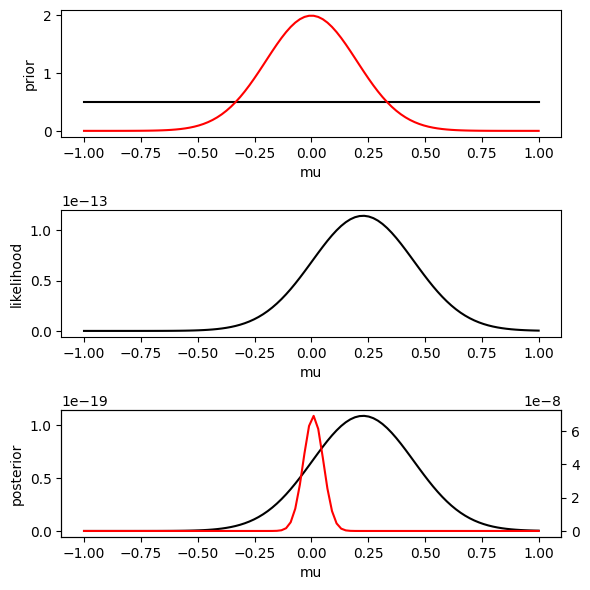

In [13]:
# Make a new figure with 3 subplots

fig = plt.figure(figsize=(6,6))
ax = fig.subplots(3, 1)

# On the first subplot, plot the uniform prior as before, and the new gaussian prior
# (Use different colours)
ax[0].plot(mus, uniform_prior(mus), 'k')
ax[0].plot(mus, gaussian_prior(mus), color='r')
ax[0].set(xlabel='mu', ylabel='prior')

# On the second subplot, plot the likelihood as before
lhs = np.array([likelihood(data, m) for m in mus])

ax[1].plot(mus, np.prod(lhs, axis=1), 'k')
ax[1].set(xlabel='mu', ylabel='likelihood')

# plot the previous posterior, and overlay the new posterior
post1 = np.array([posterior_prod(m, data) for m in mus])
post2 = np.array([posterior_gauss_prod(m, data) for m in mus])

ax[2].plot(mus, post1, 'k')
# use the right-hand y-axis, as there is a big difference in the posterior
ax[2].twinx().plot(mus, post2, 'r')

ax[2].set(xlabel='mu', ylabel='posterior')

plt.tight_layout()

In [14]:
# The likelihood of the null hypothesis that the mean is 0

pH0 = posterior_gauss_prod(0,data)

# Use spi.quad to estimate the likelihood of the alternative hypothesis as before
pH1, _ = spi.quad(posterior_gauss_prod, a=0, b=1, args=(data))

# Print Bayes Factor
print(pH0 / pH1)

15.402700337738528


You should see that the posterior is now closer to 0 and has a tighter range: using a more specific prior increases accuracy and decreases uncertainty (so long as the prior is valid).

Bayes Factor is also much larger, indicating greater evidence in favour of the null hypothesis.

\\

Things can get more complicated: we're often dealing with uncertainty across multiple parameters. Say we didn't know the standard deviation, then we would have to marginalise this out to look at the posterior mean. Marginalising is another integral, we would end up with:

\begin{align}
p(H_1|\boldsymbol{x}) = \int{ \int{ p(\boldsymbol{x}|\mu,\sigma)p(\sigma)p(\mu)d\sigma} d\mu}
\end{align}

As things get more complicated, we can switch the MCMC to estimate the integral. This is a problem for another day.

A great introduction to the MCMC approach:
van de Schoot, R., Depaoli, S., King, R., Kramer, B., Märtens, K., Tadesse, M. G., ... & Yau, C. (2021). Bayesian statistics and modelling. Nature Reviews Methods Primers, 1(1), 1.

More on Bayesian hypothesis testing:
Kruschke, J. (2014). Doing Bayesian data analysis. A tutorial with R:
JAGS, and Stan. Elsevier Science.
AKA "The puppy book"


## Part 2: Bayesian Observers

### 2a. Neual Orientation Likelihoods

Bayes is the ***'optimal'*** way to use what we know about previous 'states of the world' to have better estimates of current 'states of the world', as well as reducing our uncertainty.

Perception is a fundamental example of a useful application of Bayes: we do not have direct access to any 'truth' of the world around us, only noisy estimates from indirect measures (light, sound, et cetera).

Perception is the result of a decision about the most likely cause of the noisy and ambigous sensory evidence, which is additionally disrupted by our own noisy perceptual processes.

Using Bayes, this can be framed as taking the maximum likelihood of our
posterior estimate of the cause of our sensations:

\\

\begin{align}
p(cause | sensations) = \frac{p(sensations | cause)p(cause)} { p(sensations)}
\end{align}

\\

A basic example is in perceiving the orientation of a line.

V1, the first cortical step of visual processing, contains neurons whose firing rates are a function of orientation. Specifically, firing rate is modulated according to a circular gaussian (Von Mises) distribution, with a certain mean, mu, and concentration, kappa (~ inverse variance).





In [15]:
# Von Mises Distribution:
def vmdist(x, kappa, mu):

    pdf = (1 / (np.pi * spsc.i0(kappa))) * np.exp(kappa * np.cos(2 * (x - mu)))

    return pdf

Let's pretend V1 has 18 neurons, whose firing rates are tuned according to distributions with means equidistant across the full 180 degrees of possible orientations.

Plot the firing rates of the 18 neurons as a function of presented orientation

[Text(0.5, 0, 'Presented Orientation'), Text(0, 0.5, 'Firing rate')]

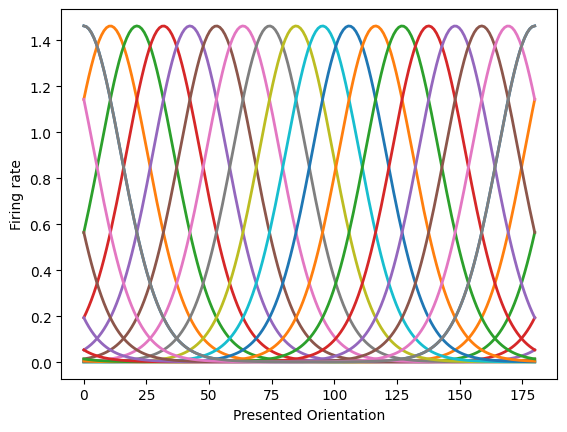

In [16]:
nneurons = 18

# Define v1mus as linearly spaced between 0 and pi
v1mus = np.linspace(0, np.pi, nneurons)

# Von Mises concentration parameter
kappa = 3.65  # estimating fwhm of about 70 deg, similar to real V1 neurons

# To plot, use an even sampling of possible presented orientations, 180 between 0 and pi
# Define oris, the samples of possible presented orientations
oris = np.linspace(0, np.pi, 180)

# Create an array of the firing rates as a function of presented orientations
# for the 18 neurons, where each row is a neuron
# Use the Von Mises distribution function defined above
v1fr = np.array([vmdist(oris, kappa, mu) for mu in v1mus])

# Plot the firing rate of each neuron as a function of presented orientation
fig, ax = plt.subplots()
for ni in range(nneurons):
    ax.plot(oris * 180 / np.pi, v1fr[ni, :], linewidth=2)
ax.set(xlabel='Presented Orientation', ylabel='Firing rate')

Neuron spike counts tend to be poisson distributed, the plot shows something proportional to mean firing rate (in response to each presented orientation), the mean is also proportional to the variance (because it's a poisson).

You should see from the plot that the firing rate of any one neuron is ambiguous with respect to which orientation was presented. For example, if the neuron maximally tuned to 90 degrees (cyan if using default colours) were firing at 0.8 of its maximal rate, this could be due to a presented orientation of either ~80 degrees or ~110 degrees.




The log-likelihood of the stimulus orientation given the neuron's spike count can be estimated as the spike count multiplied by the log of the firing rate function (Seung & Sompolinsky, 1993; Jazayeri & Movshon, 2006).

The estimate of the orientation will be the maximum a posteriori likelihood (**MAP**).


\\


Note: working with log probability is easier than working with probability

Reminder:

$log(p(A)p(B)) = log(p(A)) + log(p(B))$

$log(p(A)/p(B)) = log(p(A)) - log(p(B))$

\\

So if we want to calculate the log-likelihood of the presented orientation given the response of all neurons we can *sum* the log likelihoods across all neurons.


In [17]:
# We are going to estimate the average MAP orientation based on the average
# firing rates of our 18 neurons, in response to 15 test orientations
ntest = 15

# Define the test orientations as linearly spaced between 0 and pi
test_oris = np.linspace(0, np.pi, ntest)

# The average posterior log likelihood is the log of the firing rate function
# multiplied by the firing rate, summed over the neurons
# Calculate the averate posterior log likelihood for each presented test orientation
# (the posterior log likelihood distributed over the possible orientations defined above)
meanPost = np.sum([np.log(v1fr) * vmdist(t, kappa, v1mus)[:,np.newaxis] for t in test_oris], axis=1)

# Find the location of the maximum posterior log likelihood for each test orientation
# using np.argmax
maploc = np.argmax(meanPost, axis=1)

# The average MAP orientation is the possible orientation corresponding to
# the location of the MAP
meanMAP = np.array([oris[m] for m in maploc])

Plot the average posterior log likelihood for each test orientation and scatter the maximum a posteriori

[Text(0.5, 0, 'Orientation'), Text(0, 0.5, 'Log posterior')]

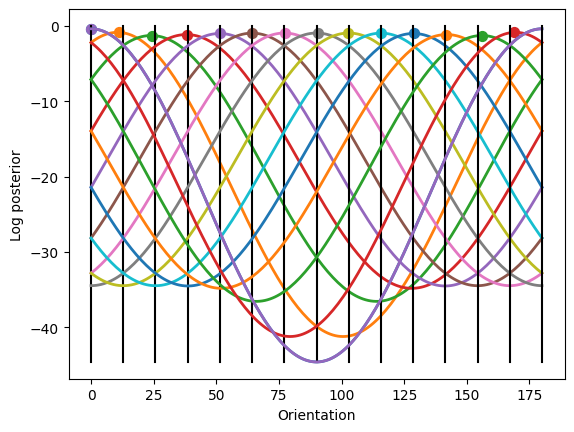

In [18]:
# Create a figure
fig, ax = plt.subplots()

# For each test orientation
for oi in range(ntest):
    # Plot the average posterior log likelihood across possible orientations
    ax.plot(oris * 180 / np.pi, meanPost[oi, :], linewidth=2)
    # scatter the average MAP orientation by max post log likelihood
    ax.scatter(meanMAP[oi] * 180 / np.pi, meanPost[oi, maploc[oi]], 50)
    # for comparison, plot lines showing the test orientations
    ax.plot([test_oris[oi] * 180 / np.pi, test_oris[oi] * 180 / np.pi], [0, np.min(meanPost)], 'k')

ax.set(xlabel='Orientation', ylabel='Log posterior')


The is the expected average MAP, given the firing rate functions.

We can also simulate the neuron firing rates, to examine variability in the MAP orientation over the multiple presentations of the test orientations.


In [19]:
# General function to get simulated neural MAP
def simMAP(test_oris,possible_oris,v1mus,kappa,v1fr,prior,nsim):

    nneurons = v1mus.shape[0] # the number of neurons
    ntest = test_oris.shape[0] # the number of test orientation

    MAP = np.zeros((ntest,nsim))

    # for each test orientation
    for ti in range(ntest):

      # posterior log likelihood is summed over all neurons
      post = np.zeros((nsim, 180))

      for ni in range(nneurons):

          # the mean firing rate in response to the test orientation
          fr = vmdist(test_oris[ti], kappa, v1mus[ni])

          # The simulated firing rates, drawn from a poisson with mean = fr
          post += sps.poisson.rvs(fr, size=(nsim, 1)) * np.log(v1fr[ni]) + np.log(prior)

      # get the MAP orientations for each test orientation
      MAP[ti] = oris[np.argmax(post, axis=1)]


    return MAP



Use this function, assuming a uniform prior over the possible orientations, to generate 100 simulated MAP orientations.


[Text(0.5, 0, 'True orientation'), Text(0, 0.5, 'Inferred orientation')]

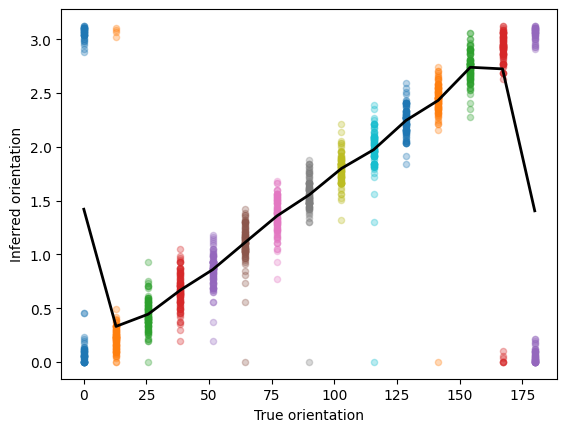

In [20]:
# Define the prior as equiprobable across the 180 possible orientations
prior = np.ones((1,180))/180

# use the function above to generate 100 simulate MAP orientations for each
# test orientation
nsim = 100
MAP = simMAP(test_oris,oris,v1mus,kappa,v1fr,prior, nsim)

# Create a scatterplot of the actual test orientations against the simulated MAP
# orientations
fig, ax = plt.subplots()
for ti in range(ntest):
    ax.scatter(np.repeat(test_oris[ti]*180/np.pi, nsim), MAP[ti], 20, alpha=0.3)

# also plot the average of the simulated MAP orientations
ax.plot(test_oris*180/np.pi, np.mean(MAP, axis=1), 'k', linewidth=2)
ax.set(xlabel='True orientation', ylabel='Inferred orientation')

### 2b. Cardinal Prior

In the real world, we are more likely to encounter orientations close vertical and horizontal (the 'Cardinal' orientations; Girshick, Landy, & Simoncelli, 2011).


This prior can be roughly described by:

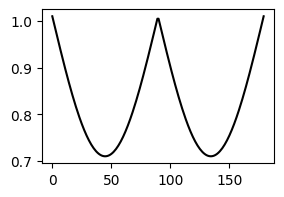

In [21]:
# Linear spacing of possible orientations
oris = np.linspace(0, np.pi, 180)
# The prior peaks at 0, 90, and 180 degrees (horizontal and vertical)
prior_ori = (1 - np.abs(np.sin(2*oris)) * 0.3) + 0.01

plt.figure(figsize=(3,2), dpi=100)
plt.plot(prior_ori, 'k')

We can look at the effect of this prior on the average estimate by adding it to the mean posterior (multiplied by the number of neurons)
since $log(p(A)*p(B)) = log(p(A)) + log(p(B))$

Add the prior, recalculate the average MAP and plot.


In [22]:
# Define a second average posterior log likelihood by adding the log of the
# prior likelihood (x nneurons) to the average posterior calculated earlier
meanPost2 = meanPost + (np.log(prior_ori) * nneurons)

# Calculate the new MAP orientation, using the armax location of the MAP as before
meanMAP2 = np.array([oris[np.argmax(meanPost2[ti])]
                     for ti in range(ntest)])

Plot the new posterior likelihood functions for each test orientation as before, scattering the MAP and marking the true test orientations.

It might help to visualise the log prior and the firing rates in subplots above this.

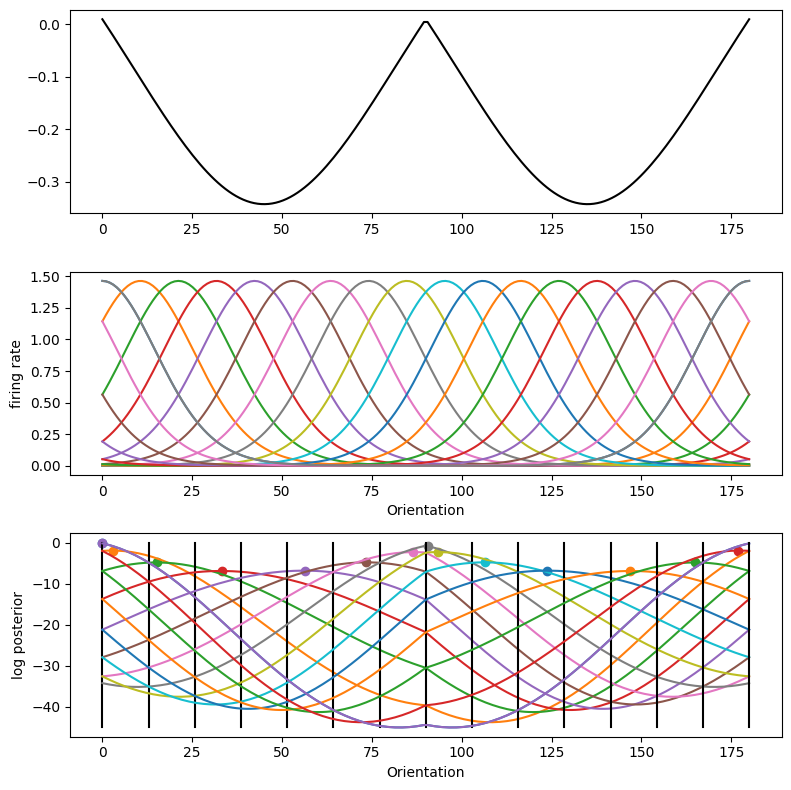

In [23]:
# Optional: plot the log prior in the first subplot
# and the firing rates in the second

fig = plt.figure(figsize=(8,8))
ax = fig.subplots(3, 1)

# plot prior
ax[0].plot(oris * 180 / np.pi, np.log(prior_ori), 'k')

# plot fr
for ni in range(nneurons):
    ax[1].plot(oris * 180 / np.pi, v1fr[ni])
ax[1].set(xlabel='Orientation', ylabel='firing rate')

# plot log posterior for each test orientation,
for oi in range(ntest):
    # plot the posterior log likelihood
    ax[2].plot(oris * 180 / np.pi, meanPost2[oi])

    # scatter the MAP orientation
    ax[2].scatter(meanMAP2[oi] * 180 / np.pi, np.max(meanPost2[oi]))

    # plot the true test orientations for comparison
    ax[2].plot([test_oris[oi] * 180 / np.pi, test_oris[oi] * 180 / np.pi], [0, np.min(meanPost2)], 'k')
ax[2].set(xlabel='Orientation', ylabel='log posterior')

plt.tight_layout()

You should see that the estimated orientations are pulled toward the cardinal orientations. Why would this be helpful?

Simulate again, and plot the estimated against the true orientation


[Text(0.5, 0, 'True orientation'), Text(0, 0.5, 'Inferred orientation')]

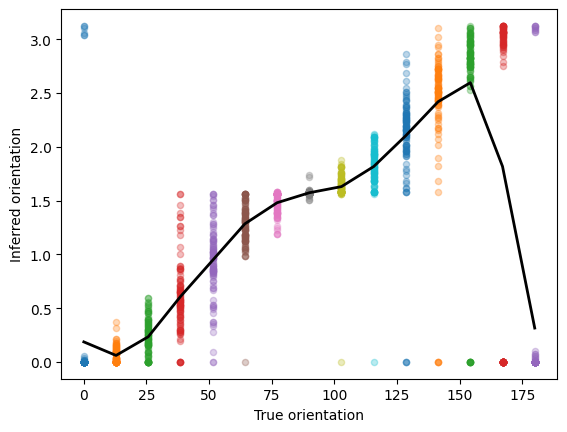

In [24]:
# Use the simMAP function again to simulate 100 MAP orientations resulting the
# test orientations with this new prior
MAP2 = simMAP(test_oris,oris,v1mus,kappa,v1fr,prior_ori, nsim)

# Scatter the simulations against the true orientation
fig, ax = plt.subplots()
for ti in range(ntest):
    ax.scatter(np.repeat(test_oris[ti]*180/np.pi, nsim), MAP2[ti], 20, alpha=0.3)

ax.plot(test_oris*180/np.pi, np.mean(MAP2, axis=1), 'k', linewidth=2)
ax.set(xlabel='True orientation', ylabel='Inferred orientation')

You should see both a bias toward horizontal/vertical, as well as the estimates being more precise around horizontal/vertical. This means that perception is more precise for orientations we encounter more often.

These are both properties reflected in human behavioural responses to
orientations (Wei & Stocker, 2015) and in BOLD responses to orientations (Patten, Mannion, & Clifford, 2017). (These two references also point to a more complex implementation via principles of 'efficient encoding', for those interested to read further).


### 2c. Biological implementation

**Save this part for after you have finished the tutorial**

How is this implemented in the brain? Do we actually track and represent priors? Or is there some way this can
be implemented in a feedforward manner?

Re-arrange the neurons so that they are spaced according to the prior (a bit more dramatic than the current prior), and plot the firing rate functions


[Text(0.5, 0, 'Orientation'), Text(0, 0.5, 'Firing rate')]

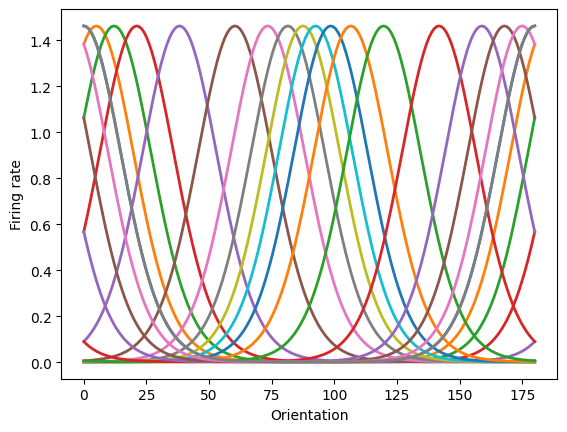

In [25]:
# To space the neurons according to the prior, we can create a cumulative probability function of the prior
thisp = np.cumsum((1 - np.abs(np.sin(2*oris)) * 0.8)) / np.sum((1 - np.abs(np.sin(2*oris)) * 0.8))

# And find samples equidistant in cumulative probability
ip = np.linspace(0.001, 0.999, nneurons)

# Place the prior means about there
v1mus_prior = np.zeros(nneurons)
for ni in range(nneurons):
    thisi = np.where(thisp >= ip[ni])[0][0]
    v1mus_prior[ni] = oris[thisi]

# Create a new array of firing rates for these neurons
v1fr_prior = np.array([vmdist(oris, kappa, mu) for mu in v1mus_prior])

# plot the firing rate over possible orientations for each neuron
fig, ax = plt.subplots()
for ni in range(nneurons):
    ax.plot(oris*180/np.pi, v1fr_prior[ni, :], linewidth=2)


ax.set(xlabel='Orientation', ylabel='Firing rate')

Recalculate the mean posterior, simulate responses and plot (as above)

[Text(0.5, 0, 'orientation'), Text(0, 0.5, 'log posterior')]

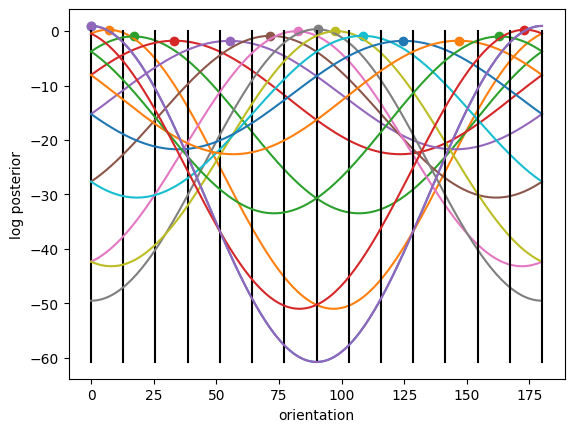

In [26]:
# The average posterior log likelihood is the log firing rate (of the prior
# distributed neurons) multiplied by the average firing rate in response to the
# test orientations, summed across neurons
meanPost3 = np.array([np.sum(vmdist(test_oris[ti], kappa, v1mus_prior)[:,np.newaxis] * np.log(v1fr_prior),
                             axis=0) for ti in range(ntest)])

# The MAP orientations, based on the location of the max posterior
meanMAP3 = np.array([oris[np.argmax(meanPost3[ti])] for ti in range(ntest)])

# plot the postior log likelihood and MAP orientations as before
fig, ax = plt.subplots()
for oi in range(ntest):
    ax.plot(oris*180/np.pi, meanPost3[oi, :])
    ax.scatter(meanMAP3[oi]*180/np.pi, np.max(meanPost3[oi]))
    ax.plot([test_oris[oi]*180/np.pi, test_oris[oi]*180/np.pi], [0, np.min(meanPost3)], 'k')

ax.set(xlabel='orientation', ylabel='log posterior')

[Text(0.5, 0, 'True orientation'), Text(0, 0.5, 'Inferred orientation')]

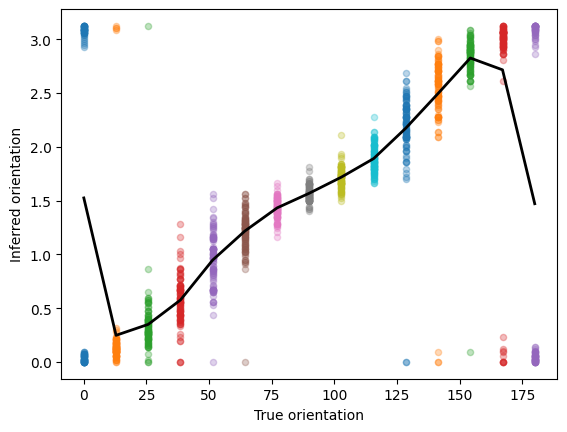

In [27]:
# Use the simMAP function again to simulate 100 MAP orientations resulting the
# test orientations with the neurons distributed this way, but inputting a
# uniform / uninformative prior
prior = np.ones((1,180))/180
MAP3 = simMAP(test_oris,oris,v1mus_prior,kappa,v1fr_prior,prior, nsim)

# scatter the MAP orientations against the true orientations as before
fig, ax = plt.subplots()
for ti in range(ntest):
    ax.scatter(np.repeat(test_oris[ti]*180/np.pi, nsim), MAP3[ti], 20, alpha=0.3)

ax.plot(test_oris*180/np.pi, np.mean(MAP3, axis=1), 'k', linewidth=2)
ax.set(xlabel='True orientation', ylabel='Inferred orientation')

You should see that having more neurons with tuning functions closer to horizontal/vertical has the same effect as the cardinal prior. The prior is now already built-in to the neural response.

Early work examining cat visual cortex has demonstrated a profound impact of early visual experience on the distribution of neuronal orientation tuning functions as well as sensitivity to orientations (Blackmore & Cooper,
1970; Hirsch & Spinelli, 1970; Hubel & Weisel, 1961).

An oversimplification: the brain builds priors into the neural tuning functions naturally, by developing more neural resources for operations that are used more often ("neurons that fire together wire together").


## Part 3: Bayesian cognition

### 3a. Tomorrow's Prior

In addition to having built-in priors at the level of sensory processing, a large body of work has examined bayesian computations at higher levels of cognitive processing.

Humans have been shown to implement Bayes-optimal inferences, but with
suboptimalities largely arising from imprecise likelihood estimates
(Drugowitsch, Wyart, et al., 2016).

This can be demonstrated using a task which requires bayesian inference.

In the task, participants are shown a sequence of visual orientation
stimuli (Gabor patches). The orientations of the entire sequence are
drawn from one of two circular gaussian (Von Mises) distributions, and
the observer is tasked with deciding which distribution the orientations were drawn from. (There is a 'colour guide' which is present throughout to help the observer visualise the distributions)



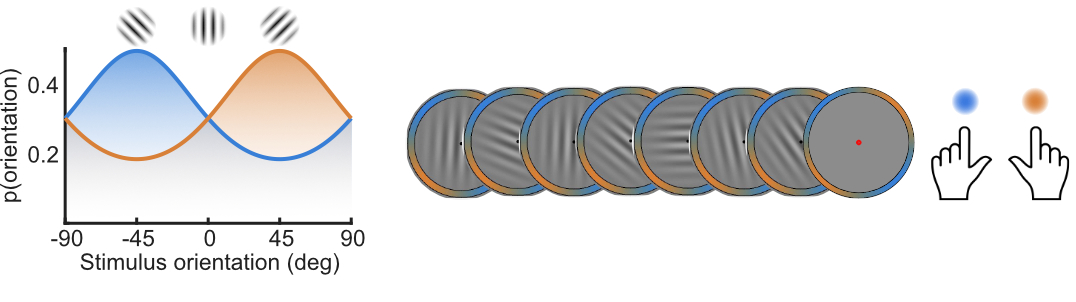

The distributions A (blue) and B (orange) are overlapping, with means at $\mu_A = \frac{-\pi}{4}$ and $\mu_B = \frac{\pi}{4}$ (assuming
vertical is at 0) and concentration parameter $\kappa_A = \kappa_B = 0.5$.

Because of the overlap, a single 'sample' (one Gabor patch) provides uncertain evidence for which distribution is the true generating distribution. For example, an orientation at 45 degrees is most likely drawn from the orange distribution (p ~= 0.5), but could also be drawn from the blue distribution with a lower likelihood (p ~= 0.2).

\\

According to Bayes theorem, the posterior probability of distribution A, given the orientation, $\theta$, is proportional to the likelihood times the prior:


\begin{align}
p(A | \theta) \propto  p(\theta | A)p(A)
\end{align}

(proportional, as we ignore $p(\theta)$ which will become irrelevant as we compare $p(A | \theta)$ with  $p(B | \theta)$ )

\\


With an equal prior for A and B ($p(A) = p(B) = 0.5$), and given the Von Mises we can see that

\begin{align}
p(A | \theta) \propto p(\theta | A)
= \frac{\exp(\kappa \cos (2(\theta-\mu_A)))}{\pi I_0(\kappa)}
\end{align}

the log is:

\begin{align}
\log(p(A | \theta)) \propto \kappa cos(2(\theta-\mu_A)) + \text{const.}
\end{align}

\\

The evidence from each sample can be summarised as

\begin{align}
evidence = \log(p(A | \theta)) - \log(p(B | \theta))
\end{align}


\\


Remember: $\exp(\log(p(A | \theta)) - \log(p(B | \theta)) = \frac{p(A | \theta)}{p(B | \theta)}$

\\

**"today’s posterior is tomorrow’s prior”** (Lindley, Bayesian statistics, a review. 1972, p. 2). This suggests at sample 2, we use the evidence from sample 1 as the prior: effectively multiplying the p's over consecutive samples
(adding the logs).

This is comparable to evidence accumulation frameworks, such as the DDM, where the observer is thought to accumulate noisy samples of evidence over time. Here, the evidence is the log-likelihood, and accumulation is the Bayes-optimal solution.


Now we will look at some data from an experiment using this task design.


This data is from Balsdon, Mamassian, & Wyart, 2021. The experiment was designed to examine how humans know how much evidence to accumulate before committing to a decision. The example data is from one participant in the 'replay' task. In this task, the participant is shown sequences of oriented Gabors (samples), and can only respond when the sequence 'finishes' (the fixation mark turns red and no more Gabors are presented). The number of samples shown (sequence length) is specified relative to the number the human chose to respond to when viewing that same sequence, but in a different setting where they could respond after any number of samples (as soon as they 'felt ready').

Here we will look at how the human performs based on how many samples they were shown.

Load the example stimulus evidence and the example participant data.

In [28]:
#T = pd.read_csv('../Downloads/SUB001_stopExp_replay.csv', header=None)
#data = T.values

#T = pd.read_csv('../Downloads/SUB001_stopExp_evidence.csv', header=None)
#evidence = T.values

T = pd.read_csv('SUB001_stopExp_replay.csv',header=None)
data = T.values
T = pd.read_csv('SUB001_stopExp_evidence.csv',header=None)
evidence = T.values
print(evidence.shape, data.shape)

(100, 40) (300, 11)


Ignore the variable 'data' for now, we will get to this later.

The variable 'evidence' is a matrix (100x40).
This is not really the evidence, it is 100 prespecified sequences of 40 orientations (in degrees). For the first 50 sequences, the orientations were drawn from distribution A (correct response = 0) and the second 50 sequences, from distribution B (correct response = 1).

On each trial, one of these sequences is selected and the human is shown the first N samples (sequence length = N). Each sequence is shown 3 times (300 trials in total), and each time with a different sequence length.

The optimal observer accumulates evidence from each sample, and so should be more likely choose the correct generating distribution when shown more samples.

Transform the evidence into the log likelihood of A vs B and visualise

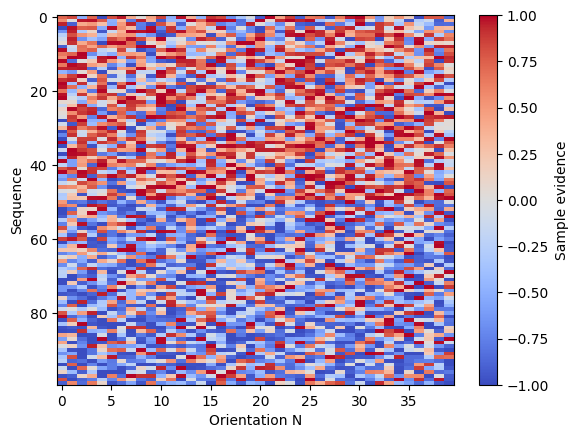

In [29]:
# The log likelihood of Distribution A, given the orientation evidence is:
logpA = 0.5 * np.cos(2 * ((evidence * np.pi / 180) + (np.pi / 4)))

# Define the log likelihood of Distribution B given the orientation evidence
logpB = 0.5 * np.cos(2 * ((evidence * np.pi / 180) - (np.pi / 4)))

# Summarise the sample evidence as the difference in log likelihoods
sampleEvidence = logpA - logpB

# visualise the sample evidence of each sample in each sequence (using imshow)
plt.imshow(sampleEvidence, aspect='auto', cmap='coolwarm')
plt.xlabel('Orientation N')
plt.ylabel('Sequence')
plt.colorbar(label='Sample evidence')

You should see the first 50 sequences the evidence is more likely to be greater than 0, the second 50 is is more likely to be less than 0.

How would an optimal observer perform, as a function of sequence length?

The optimal observer should accumulate the evidence from each sample, and decide based on whether the accumulated evidence is greater than 0.

Plot the evidence, accumulating (summing) each consecutive sample.

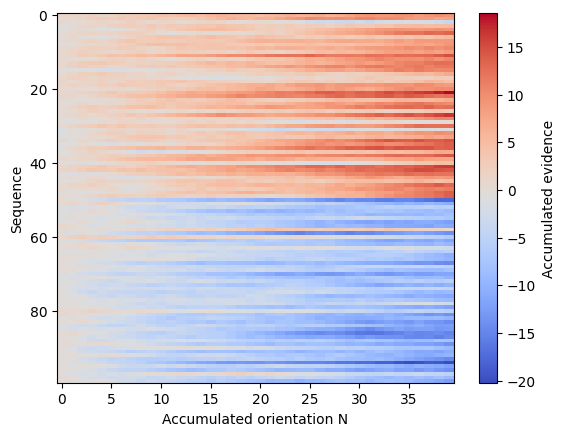

In [30]:
# Use imshow again, with np.cumsum to accumulate the evidence from each sample
plt.imshow(np.cumsum(sampleEvidence, axis=1), aspect='auto', cmap='coolwarm')
plt.xlabel('Accumulated orientation N')
plt.ylabel('Sequence')
plt.colorbar(label='Accumulated evidence')

You should see that, as the sequence length increases, the evidence is more likely to favour the correct generating distribution: The first 50 sequences are more likely to be greater than 0 (and increasing away from 0); the second 50 are more likely to be less than 0 (and decreasing away from 0).

The optimal observer chooses distribution A if the accumulated evidence is greater than 0 and distribution B is it is less than 0. Code this as a response of 0 (choosing distribution A) accumulated evidence greater than 0 and 1 (choosing distribution B) for less than 0.

Examine how the proportion of correct responses increases as a function of sequence length.


In [31]:
# Define the response for each sequence length, for each sequence,
# determined by whether the accumulated evidence is less than 0
resps = (np.cumsum(sampleEvidence, axis=1) < 0)

# is response correct for each sequence and each sequence length?
is_correct = resps == np.concatenate([np.zeros([50,1]), np.ones([50,1])])

# Calculate the percentage correct over all sequences, for each sequence length
optimal_pcorr = np.mean(is_correct, axis=0)


Plot proportion correct by number of samples accumulated (sequence length)

Text(0, 0.5, 'Proportion correct')

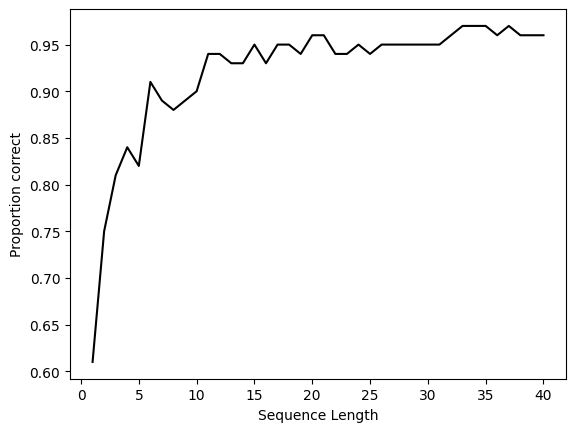

In [32]:
# For the x-axis, range from 1 to 40
maxSamps = 40
seq_len = np.arange(maxSamps) +1

plt.figure()
plt.plot(seq_len, optimal_pcorr, 'k')
plt.xlabel('Sequence Length')
plt.ylabel('Proportion correct')

You should see that if the optimal observer were only shown 1 sample (sequence length = 1) they would only achieve just over 60% correct. This increases rapidly: if they were shown 5 samples (sequence length = 5), performance is around 80% correct.

The performance of the optimal observer is limited by the uncertainty of the generating distributions. If the distributions had a lower concentration (kappa), that is, they overlap more, then the performance of the optimal observer would be worse. Inversely, a greater concentration, less overlap, better performance.

# **3b. Optimal vs Human**

How does our human participant compare?

The data is made up of 300 rows (trials) with 11 columns:

  0. **Block number** 1 to 3 (three blocks of 100 trials)
  1. **Trial number** 1 to 300
  2. **Condition** -2, 0, 4 (this is related to how many stimuli the participant was shown)
  3. $\color{blue}{Trial Index}$ 1 to 100 - what row of the evidence matrix defines the orientations presented on that trial
  4. **Distribution** 1 or 2 - the true generating distribution
  5. $\color{blue}{Sequence Length}$ the number of stimuli presented on that trial
  6. **Old Stop** the number of stimuli the observer chose to respond after in a different version of the task (Sequence length + Condition = Old Stop)
  7. $\color{blue}{Response}$ 1 or 2 the distribution the participant chose
  8. $\color{blue}{Correct}$ whether the response was correct (1) or not (0)
  9. **Confidence** 1 to 4, a rating by the participant of how confidence they were that they were correct
  10. **RT** response time, in seconds, from the beginning of the trial (stimuli were presented at a rate of 4 Hz (4 per second))

In blue are the columns important for the analysis below: columns 3, 5, 7, and 8.

Calculate the participant's proportion correct by the sequence length.

In [33]:
# Extract the sequence length for each trial shown to the human participant
# (column 5)
pt_seq_len = data[:,5].astype('int')

# Extract whether the participant responded correctly (1/0) (column 8)
pt_correct = data[:,8]

In [34]:
# Calculate proportion correct over 20 bins of sequence length
n_bins = 20

# Use sps.binned_statistic, returning the participant proportion correct,
# the bin edges, and the bin id for each trial
pt_pcorr, bins, bin_id = sps.binned_statistic(pt_seq_len, pt_correct, bins=n_bins)

# Calculate the mean bin location (the left edge + half the difference in bin width)
bin_means = bins[:-1] + np.diff(bins)[0]/2

# Calculate the number of trials per bin (for visualisation)
ntrials_perbin = np.array([np.sum(bin_id==b) for b in range(n_bins)])

Scatter the human proportion correct compared to the plot of the optimal proportion correct

(0.5, 1.1)

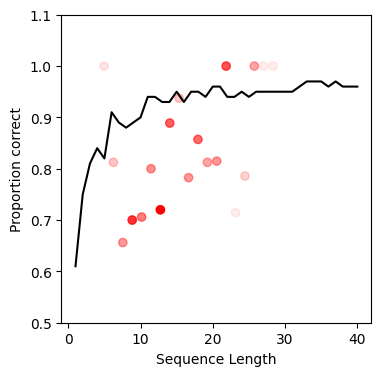

In [35]:

# plot the optimal proportion correct by sequence length again
plt.figure(figsize=(4,4), dpi=100)
plt.plot(seq_len, optimal_pcorr, color='k')
# scatter the human proportion correct
# Tip: use alpha=ntrials_perbin/ntrials_perbin.max() to help visualise
plt.scatter(bin_means, pt_pcorr, alpha=ntrials_perbin/ntrials_perbin.max(), color='r')

plt.xlabel('Sequence Length')
plt.ylabel('Proportion correct')
plt.ylim(.5,1.1)

The plot for the optimal observer actually shows performance by sequence length across all predefined sequences. The scatter for the human observer shows performance by sequence length for the specific sequences that were shown with that sequence length. A better comparison would be to take the same sequences for the optimal observer as were shown to the human.

In [36]:
# Each of the 300 trials has a reference to the row corresponding to the
# sequence shown on that trial (column 3)
exp_evmat_id = (data[:,3]-1).astype('int')

# For each trial, would the optimal observer be correct for that sequence length
# tip: use for i,l in zip(exp_evmat_id, pt_seq_len) to index
exp_is_correct = np.array([is_correct[i,l] for i,l in zip(exp_evmat_id, pt_seq_len)])

# Get the binned proportion correct as we did for the human participant
exp_optimal_pcorr, _, _ = sps.binned_statistic(pt_seq_len, exp_is_correct, bins=n_bins)

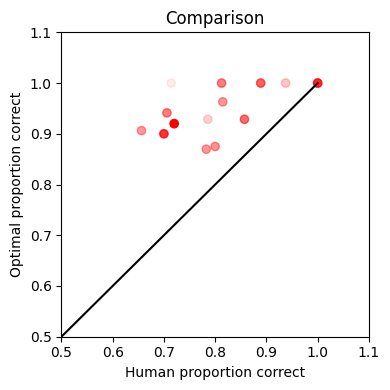

In [37]:

# Scatter the human compared to the optimal proportion correct
plt.figure(figsize=(4,4), dpi=100)
plt.title('Comparison')
plt.plot([0.5,1], [0.5,1], 'k')
plt.scatter(pt_pcorr, exp_optimal_pcorr, alpha=ntrials_perbin/ntrials_perbin.max(), color='r')

plt.ylim(.5,1.1)
plt.xlim(.5,1.1)

plt.xlabel('Human proportion correct')
plt.ylabel('Optimal proportion correct')
plt.tight_layout()

# **3c. Estimating Suboptimalities**

The human is clearly doing less well than the bayes-optimal observer.

We can describe two sources of suboptimality:

1. **Inference noise**, where the human has a noisy estimate of the loglikelihood. We parameterise this as sigma, the standard deviation of additive gaussian noise

2. **Temporal bias**, where the human might weight more strongly the recent samples, or the initial samples. We parameterise this as alpha, an exponential weighting function.

To estimate these suboptimalities, we create a numerical description of
the underlying inference process (computational model).


In [38]:
def probabilityOfResponse(params, xsamp):

    sigma = params[0]
    alpha = np.exp(params[1]) # take the exponential

    xpost = np.zeros((len(xsamp), 2))
    spost = np.zeros((len(xsamp), 2))

    # loop over trials: xsamp is zip object of evA and evB, so each x will be (trial-specific) seq_len x 2
    for ti,x in enumerate(xsamp):

        # loop over orientations
        for si in range(len(x)):
            xpost[ti] = xpost[ti]*alpha + x[si]
            spost[ti] = spost[ti]*alpha + sigma

    # units of sd
    xpost = xpost*np.pi/np.sqrt(6)/spost

    # e-softmax
    ppost = np.exp(xpost)/np.sum(np.exp(xpost),axis=1)[:,np.newaxis]
    ppost = np.maximum(ppost,0.001)

    return ppost


def resp_nLL(params, xsamp, resp):

    ppost = probabilityOfResponse(params, xsamp)
    nll = -np.sum(np.log([p[r] for p,r in zip(ppost, resp)]))

    return nll

The first function calculates the probability of choosing distribution A and B for each trial.

`xsamp` is the evidence from the presented orientations for each sequence (separately for A and B).

The second function calculates the negative log likelihood of the human's choices.

`resp` is the id of the response for each trial

Next, we find the values of the parameters (`params`) that gives the smallest `nLL`

\\

Note: by finding the smallest negative log likelihood, we are effectively finding the maximum log likelihood. If we had some prior uncertainty over parameter values, this model fitting exercise could be performed using a bayesian approach.

In [39]:

# Define the log evidence, separately for A and B, for each sequence shown (in order)
# stack evA and evB for each trial into sequence length for that trial x 2
xsamp = [np.stack([logpA[i], logpB[i]])[:,:pt_seq_len[ii]].T
         for ii,i in enumerate(exp_evmat_id)]

# to take only the log probabilities corresponding to the human response
response = data[:,7].astype(int)-1

Fit the model by minimising the negative log likelihood of the responses


In [40]:

# the model has two parameters, sigma and alpha
# initialise these at sigma = 1 and alpha 0
sigma = 1
alpha = 0
# the variable pfit_ini should be numpy array of [sigma, alpha]
pfit_ini = np.array([sigma, alpha])  # sigma, alpha

# sigma cannot be less than 0, so create bounds on the parameter values
# 0.01 < sigma < 10 and -10 < alpha < 10 should do
# similar to pfit_ini create pfit_min and pfit_max describing the lower and upper bounds
pfit_min = np.array([0.01, -10])
pfit_max = np.array([10, 10])

# Function to minimise
result = spo.minimize(fun=resp_nLL,
                      x0=pfit_ini,
                      args=(xsamp, response),# all the other arguments that are not parameters to be estimated, i.e., xsamps, seq_len, iresp,
                      bounds=list(zip(pfit_min, pfit_max)),
                      options={'disp': True})

params = result.x

In [41]:
print(result)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 119.23199651378741
        x: [ 1.929e-01 -1.461e-01]
      nit: 13
      jac: [ 1.421e-05 -1.421e-06]
     nfev: 78
     njev: 26
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


Simulate the model responses and summarise proportion correct over bins of sequence length in the same way as before




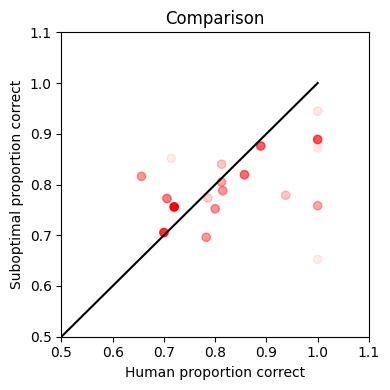

In [42]:
# Use the function probabilityOfResponse with the parameters fit above
ppost = probabilityOfResponse(params, xsamp)

# Extract the probability of making the same response as the participant
# (see the code in the resp_nLL function for a hint)
model_correct = np.array([p[r] for p,r in zip(ppost, response)])

# The probability of making the same response as the participant is the
# probability correct, when the participant is correct
# On trials where the participant was incorrect, take 1- to get probability correct
model_correct[pt_correct==0] = 1 - model_correct[pt_correct==0]

# get bins of proportion correct as before
model_pcorr, _, _ = sps.binned_statistic(pt_seq_len, model_correct, bins=n_bins)

# Scatter the human against the model proportion correct
plt.figure(figsize=(4,4), dpi=100)
plt.title('Comparison')
plt.plot([0.5,1], [0.5,1], 'k')
plt.scatter(pt_pcorr, model_pcorr, alpha=ntrials_perbin/ntrials_perbin.max(), color='r')

plt.ylim(.5,1.1)
plt.xlim(.5,1.1)

plt.xlabel('Human proportion correct')
plt.ylabel('Suboptimal proportion correct')
plt.tight_layout()

The model isn't perfect.

This exercise should demonstrate the usefulness of defining an optimal
way to solve a task (maximise accuracy) and comparing specific ways
humans might differ from this optimal solution
